## Importes

Realizamos los importes necesarios para nuestro modelo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import pickle
import seaborn as sns
import requests

from ast import literal_eval

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn import svm
from scipy.stats import randint
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
partes_train = []
cant_partes = 2
for i in range(cant_partes):
  parte = pd.read_csv(f'https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/train_data_procesado_FILTRADO_FINAL_parte_{i}.csv')
  partes_train.append(parte)
train_data = pd.concat(partes_train, ignore_index=True)

test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/train_tp2/test_data_procesado_FILTRADO_FINAL.csv"
test_data = pd.read_csv(test_url)

Concatenamos los tokens en una unica lista de texto y lo utilizamos para crear y entrenar el vectorizer; tanto para train como para test

In [3]:
#Transformamos train_data['tokens'] y test_data['tokens] en listas reales (antes eran representaciónes de lista hechas en string)
train_data['tokens'] = train_data['tokens'].apply(literal_eval)
test_data['tokens'] = test_data['tokens'].apply(literal_eval)

vectorizer = CountVectorizer()

corpus = [' '.join(tokens) for tokens in train_data['tokens']]
X = vectorizer.fit_transform(corpus)

corpus_test = [' '.join(tokens) for tokens in test_data['tokens']]
X_test_data = vectorizer.transform(corpus_test)

Obtenemos las etiquetas y dividivos los datos en conjunto de train y test

In [4]:
y = train_data['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Dado que Random Forest tarda en correr, vamos a obtener una subclasificación de nuestra división de datos, así mejoramos el tiempo de optimización de hiperparametros

In [5]:
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=10000, stratify=y_train, random_state=42)

## Funciones

A Continuación, crearemos distintas funciones que serán utilizadas a lo largo del trabajo.

### mostrar_resultados

Esta función, recibe los mejores parametros encontrados, los conjuntos de datos tanto de entrenamiento como de prueba y nos muestra las distintas metricas obtenidas del modelo.

In [6]:
def mostrar_resultados(model, best_params, X_train, y_train, X_test, y_test):
  print("Mejores hiperparámetros encontrados:", best_params)

  # Metricas en el conjunto de entrenamiento
  y_train_pred = model.predict(X_train)

  print("Métricas de evaluación en el conjunto de entrenamiento:")
  print("Accuracy:", accuracy_score(y_train, y_train_pred))
  print("Recall:", recall_score(y_train, y_train_pred, average='macro'))
  print("F1-Score:", f1_score(y_train, y_train_pred, average='macro'))
  print("Precision:", precision_score(y_train, y_train_pred, average='macro'))

  # Metricas en el conjunto de prueba
  y_test_pred = model.predict(X_test)

  print("\nMétricas de evaluación en el conjunto de prueba:")
  print("Accuracy:", accuracy_score(y_test, y_test_pred))
  print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
  print("F1-Score:", f1_score(y_test, y_test_pred, average='macro'))
  print("Precision:", precision_score(y_test, y_test_pred, average='macro'))

### mostrar_matriz_confusion

La siguiuente función recibe un modelo, y los conjuntos de datos tanto de entrenamiento como de prueba y nos muestra la matriz de confusión correspondiente para cada caso

In [7]:
def mostrar_matriz_confusion(model, X_train, y_train, X_test, y_test):
  y_train_pred = model.predict(X_train)
  cm_train = confusion_matrix(y_train, y_train_pred)

  class_labels = ['Negativo', 'Positivo']
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Matriz de Confusión en el conjunto de entrenamiento')
  plt.show()

  print("\n\n")

  y_test_pred = model.predict(X_test)
  cm_train = confusion_matrix(y_test, y_test_pred)
  class_labels = ['Negativo', 'Positivo']
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title('Matriz de Confusión en el conjunto de prueba')

  plt.show()

## SVM

La consigna no pedía utilizar SVM, pero lo utilizaremos luego para realizar el ensamble.

Creamos el modelo de SVM y definimos los hiperparámetros a usar

In [ ]:
svm_clf = svm.SVC()

hyperparameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 0.5, 1]
}

\Realizamos la optimización de los hiperparametros utliizando Random Search con Cross Validation de 5

In [ ]:
random_search = RandomizedSearchCV(svm_clf, hyperparameters, cv=5, n_iter=5, random_state=42)
random_search.fit(X_train_sub, y_train_sub)

RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=5,
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': [0.1, 0.5, 1],
                                        'kernel': ['linear', 'rbf']},
                   random_state=42)

Obtenemos los mejores parametros y entrenamos el modelo a partir de ellos

In [ ]:
best_params_sv = random_search.best_params_

best_svm_clf = svm.SVC(**best_params_sv)
best_svm_clf.fit(X_train, y_train)

SVC(C=0.1, gamma=0.1, kernel='linear')

Mostramos los resultados conseguidos

In [ ]:
mostrar_resultados(best_svm_clf, best_params_sv, X_train, y_train, X_test, y_test)

Mejores hiperparámetros encontrados: {'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}
Métricas de evaluación en el conjunto de entrenamiento:
Accuracy: 0.9248764621254769
Recall: 0.9248882817069697
F1-Score: 0.9248764327325896
Precision: 0.9248924045926546

Métricas de evaluación en el conjunto de prueba:
Accuracy: 0.8296117921774664
Recall: 0.829630943802619
F1-Score: 0.8296036035160036
Precision: 0.8297143385745103


Vemos ambas matriecs de confusión

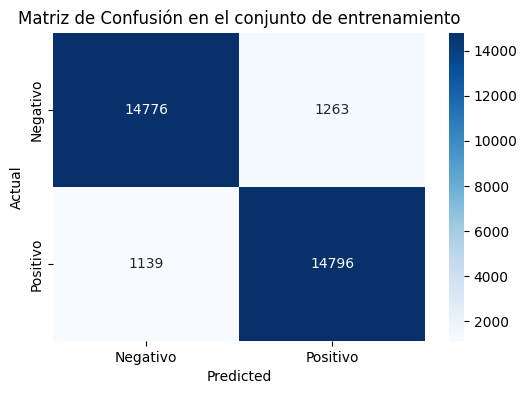

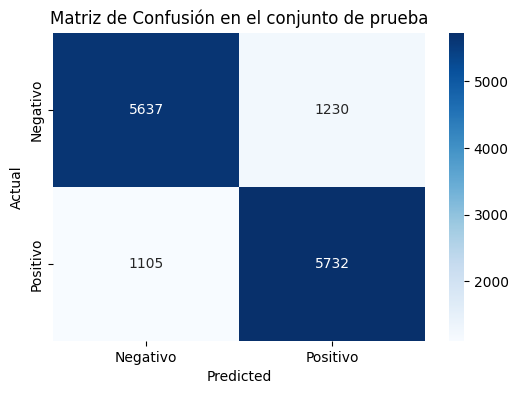

In [ ]:
mostrar_matriz_confusion(best_svm_clf, X_train, y_train, X_test, y_test)

Guardamos y cargamos el modelo

In [ ]:
with open('modelo_svm.pkl', 'wb') as file:
    pickle.dump(best_svm_clf, file)

with open('modelo_svm.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

Realizamos la predicción correspondiente, cambiando 0 y 1 por negativo y positivo

In [ ]:
y_test_data_pred = loaded_model.predict(X_test_data)
y_test_data_pred = np.where(y_test_data_pred == 0, 'negativo', 'positivo')

Y conseguimos el dataframe, guardando el csv para realizar la predicción en Kaggle

In [ ]:
predictions_df = pd.DataFrame({'ID': test_data['ID'], 'sentimiento': y_test_data_pred})
predictions_df.to_csv('predicciones_svm_1.csv', index=False)

## Ensamble Voting

Cargamos los modelos que utilizaremos para el ensamble de Voting

In [ ]:
response_bn = requests.get("https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/Modelos_tp2/modelo_naive_bayes.pkl")
content_bn = response_bn.content
with open("modelo_naive_bayes.pkl", 'wb') as file_bn:
    file_bn.write(content_bn)

with open("modelo_naive_bayes.pkl", 'rb') as file_bn:
    model1 = pickle.load(file_bn)

response_rf = requests.get("https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/Modelos_tp2/modelo_random_forest.pkl")
content_rf = response_rf.content
with open("modelo_random_forest.pkl", 'wb') as file_rf:
    file_rf.write(content_rf)

with open("modelo_random_forest.pkl", 'rb') as file_rf:
    model2 = pickle.load(file_rf)

response_svm = requests.get("https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/Modelos_tp2/modelo_svm.pkl")
content_svm = response_svm.content
with open("modelo_svm.pkl", 'wb') as file_svm:
    file_svm.write(content_bn)

with open("modelo_svm.pkl", 'rb') as file_svm:
    model3 = pickle.load(file_svm)

Realizamos el respetivo entrenamiento

In [ ]:
ensamble_soft = VotingClassifier(estimators=[('bn', model1), ('rf', model2), ('sv', model3)], voting='hard', n_jobs=-1)

ensamble_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('bn', MultinomialNB(alpha=3, fit_prior=False)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features='log2',
                                                     min_samples_leaf=3,
                                                     min_samples_split=10,
                                                     n_estimators=140,
                                                     random_state=42)),
                             ('sv', SVC(C=0.1, gamma=0.1, kernel='linear'))],
                 n_jobs=-1)

Mostramos las metricas tanto de entrenamiento como de prueba

In [ ]:
mostrar_resultados(ensamble_soft, "No hay parametros", X_train, y_train, X_test, y_test)

Mejores hiperparámetros encontrados: No hay parametros
Métricas de evaluación en el conjunto de entrenamiento:
Accuracy: 0.8562269343841872
Recall: 0.8562432158372675
F1-Score: 0.8562262254556956
Precision: 0.8562605353136671

Métricas de evaluación en el conjunto de prueba:
Accuracy: 0.8290280210157618
Recall: 0.8290439749332471
F1-Score: 0.8290228998860778
Precision: 0.8290991756516217


Y hacemos lo mismo para las matrices de confusión

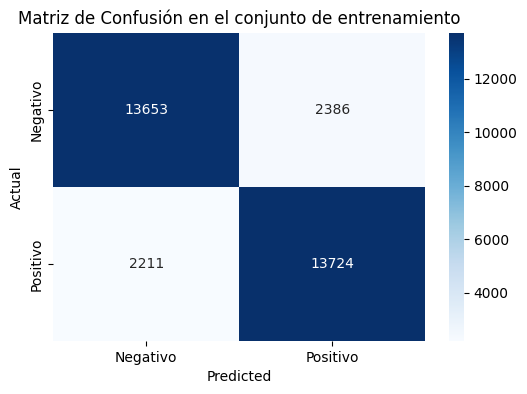

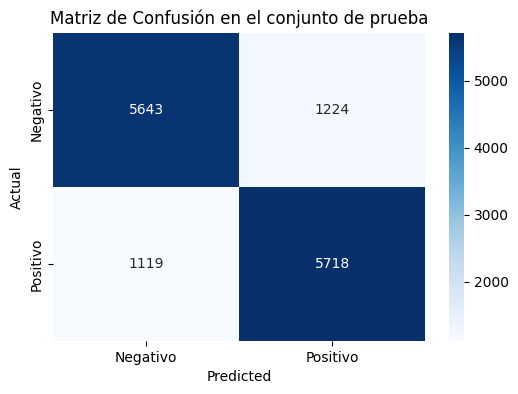

In [ ]:
mostrar_matriz_confusion(ensamble_soft, X_train, y_train, X_test, y_test)

Guardamos el modelo en formato .pkl y lo cargamos

In [ ]:
with open('ensamble_voting.pkl', 'wb') as file:
    pickle.dump(ensamble_soft, file)

with open('ensamble_voting.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

Realizamos las predicciones correspondientes, cambiando 1 y 0 por positivo y negativo

In [ ]:
y_test_data_pred = loaded_model.predict(X_test_data)
y_test_data_pred = np.where(y_test_data_pred == 0, 'negativo', 'positivo')

Obtenemos el dataframe y lo guardamos en formato csv para subirlo a la competencia de Kaggle

In [ ]:
predictions_df = pd.DataFrame({'ID': test_data['ID'], 'sentimiento': y_test_data_pred})
predictions_df.to_csv('predicciones_vooting.csv', index=False)

## Ensamble Stacking

Cargamos los modelos que utilizaremos para los ensambles, estos son Bayes Naieve, Random Forest y SVM

In [8]:
response_bn = requests.get("https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/Modelos_tp2/modelo_naive_bayes.pkl")
content_bn = response_bn.content
with open("modelo_naive_bayes.pkl", 'wb') as file_bn:
    file_bn.write(content_bn)

with open("modelo_naive_bayes.pkl", 'rb') as file_bn:
    model1 = pickle.load(file_bn)

response_rf = requests.get("https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/Modelos_tp2/modelo_random_forest.pkl")
content_rf = response_rf.content
with open("modelo_random_forest.pkl", 'wb') as file_rf:
    file_rf.write(content_rf)

with open("modelo_random_forest.pkl", 'rb') as file_rf:
    model2 = pickle.load(file_rf)

response_svm = requests.get("https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/Modelos_tp2/modelo_svm.pkl")
content_svm = response_svm.content
with open("modelo_svm.pkl", 'wb') as file_svm:
    file_svm.write(content_bn)

with open("modelo_svm.pkl", 'rb') as file_svm:
    model3 = pickle.load(file_svm)

#### Logistic Regression

Empezaremos con Regresión Logistica, realizando el respetivo entrenamiento

In [9]:
meta_model = LogisticRegression()

stacking_clf_lr = StackingClassifier(estimators=[('bn', model1), ('rf', model2), ('sv', model3)], final_estimator=meta_model)
stacking_clf_lr.fit(X_train_sub, y_train_sub)

StackingClassifier(estimators=[('bn', MultinomialNB(alpha=3, fit_prior=False)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_features='log2',
                                                       min_samples_leaf=3,
                                                       min_samples_split=10,
                                                       n_estimators=140,
                                                       random_state=42)),
                               ('sv', MultinomialNB(alpha=3, fit_prior=False))],
                   final_estimator=LogisticRegression())

Mostramos las metricas tanto de entrenamiento como de prueba

In [10]:
mostrar_resultados(stacking_clf_lr, "No hay parametros", X_train, y_train, X_test, y_test)

Mejores hiperparámetros encontrados: No hay parametros
Métricas de evaluación en el conjunto de entrenamiento:
Accuracy: 0.8436542190529805
Recall: 0.843648597522516
F1-Score: 0.8436510917281959
Precision: 0.8436560963841784

Métricas de evaluación en el conjunto de prueba:
Accuracy: 0.8264740221833041
Recall: 0.8264840532775528
F1-Score: 0.8264726879237141
Precision: 0.826502023181626


Y hacemos lo mismo para las matrices de confusión

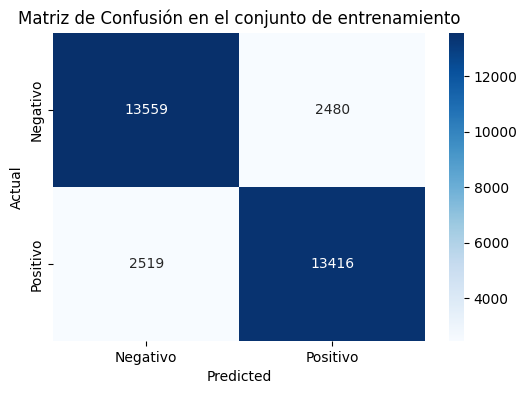

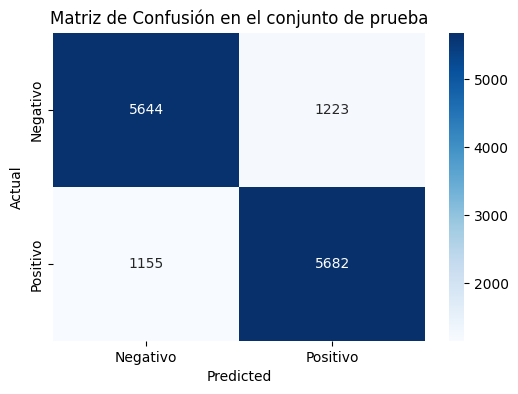

In [11]:
mostrar_matriz_confusion(stacking_clf_lr, X_train, y_train, X_test, y_test)

#### Support Vector Classifier

Replicamos lo anterior para SVC

In [12]:
meta_model = SVC()

stacking_clf_svc = StackingClassifier(estimators=[('bn', model1), ('rf', model2), ('sv', model3)], final_estimator=meta_model)
stacking_clf_svc.fit(X_train_sub, y_train_sub)

StackingClassifier(estimators=[('bn', MultinomialNB(alpha=3, fit_prior=False)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_features='log2',
                                                       min_samples_leaf=3,
                                                       min_samples_split=10,
                                                       n_estimators=140,
                                                       random_state=42)),
                               ('sv', MultinomialNB(alpha=3, fit_prior=False))],
                   final_estimator=SVC())

In [13]:
mostrar_resultados(stacking_clf_svc, "No hay parametros", X_train, y_train, X_test, y_test)

Mejores hiperparámetros encontrados: No hay parametros
Métricas de evaluación en el conjunto de entrenamiento:
Accuracy: 0.8418402451992244
Recall: 0.8418354183078183
F1-Score: 0.8418374256653223
Precision: 0.8418410157585212

Métricas de evaluación en el conjunto de prueba:
Accuracy: 0.8266199649737302
Recall: 0.8266319137134037
F1-Score: 0.8266176568973509
Precision: 0.8266597443398358


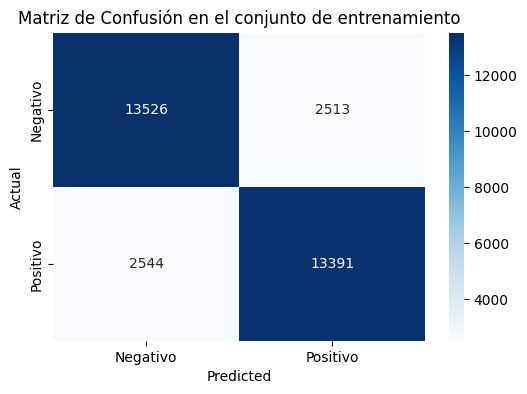

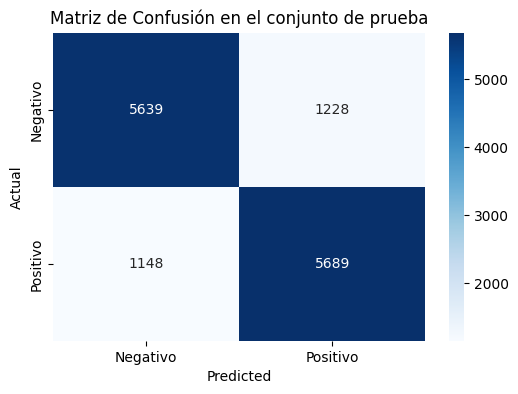

In [14]:
mostrar_matriz_confusion(stacking_clf_svc, X_train, y_train, X_test, y_test)

#### Mejor resultado

Realizando la comparación de métricas, podemos que ambos modelos tienen resultados muy similares. Aunque parece un poco mejor por muy poco el modelo de Regresión Logistica.

In [22]:
best_stacking = stacking_clf_lr

Guardamos los modelos en formato .pkl y los cargamos

In [23]:
with open('ensamble_stacking_svc.pkl', 'wb') as file:
    pickle.dump(best_stacking, file)

with open('ensamble_stacking_svc.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

Realizamos las predicciones correspondientes a ambos, cambiando 1 y 0 por positivo y negativo

In [24]:
y_test_data_pred = loaded_model.predict(X_test_data)
y_test_data_pred = np.where(y_test_data_pred == 0, 'negativo', 'positivo')

Obtenemos el dataframe y lo guardamos en formato csv para subirlo a la competencia de Kaggle

In [25]:
predictions_df = pd.DataFrame({'ID': test_data['ID'], 'sentimiento': y_test_data_pred})
predictions_df.to_csv('predicciones_best_stacking.csv', index=False)